# Knowledge Graph Analysis

This notebook analyzes two knowledge graph representations:
1. JSON-based knowledge graph (`extracted_terms.json`)
2. SKOS/RDF-based knowledge graph (`extracted_terms_skos.ttl`)

The main focus is to identify and analyze dangling edges in both representations.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from rdflib import Graph, Namespace, URIRef
from collections import Counter
import seaborn as sns
from IPython.display import display, HTML

# Set plot styling
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

## 1. JSON Knowledge Graph Analysis

In [2]:
# Load the JSON knowledge graph
with open('scratch/extracted_terms.json', 'r') as f:
    kg_data = json.load(f)

print(f"Metadata: Extraction Date: {kg_data['metadata']['extraction_date']}")
print(f"Files processed: {kg_data['metadata']['processed_files']}")
print(f"Pages processed: {kg_data['metadata']['processed_pages']}")
print(f"Total terms: {len(kg_data['terms'])}")

Metadata: Extraction Date: 2025-03-28T00:25:40.415846Z
Files processed: 73
Pages processed: 1528
Total terms: 4239


In [3]:
# Create a directed graph from the JSON data
G = nx.DiGraph()

# Track unique terms and term categories
all_terms = set()
term_categories = {}

# Add nodes (terms) to the graph
for term_entry in kg_data['terms']:
    term = term_entry['term']
    category = term_entry.get('category', 'unknown')
    
    all_terms.add(term)
    term_categories[term] = category
    
    # Add node with attributes
    G.add_node(term, 
               category=category,
               definition=term_entry.get('definition', ''),
               papers=len(term_entry.get('source_papers', [])))

print(f"Added {len(all_terms)} unique terms as nodes")

Added 4239 unique terms as nodes


In [4]:
# Add edges (relations) to the graph
total_relations = 0
empty_target_relations = 0
dangling_relations = 0

for term_entry in kg_data['terms']:
    source_term = term_entry['term']
    
    for relation in term_entry.get('relations', []):
        relation_type = relation['relation']
        target_term = relation.get('related_term', '')  # Use get with default empty string
        
        total_relations += 1
        
        # Skip empty target relations
        if not target_term:
            empty_target_relations += 1
            continue
        
        # Check if target exists in our nodes
        if target_term not in all_terms:
            dangling_relations += 1
        
        # Add the edge regardless (for analysis)
        G.add_edge(source_term, target_term, relation=relation_type)

print(f"Total relations: {total_relations}")
print(f"Empty target relations: {empty_target_relations} ({empty_target_relations/total_relations*100:.2f}%)")
print(f"Dangling relations (target not in nodes): {dangling_relations} ({dangling_relations/total_relations*100:.2f}%)")
print(f"Valid relations: {total_relations - empty_target_relations - dangling_relations} ({(total_relations - empty_target_relations - dangling_relations)/total_relations*100:.2f}%)")

Total relations: 17029
Empty target relations: 864 (5.07%)
Dangling relations (target not in nodes): 11012 (64.67%)
Valid relations: 5153 (30.26%)


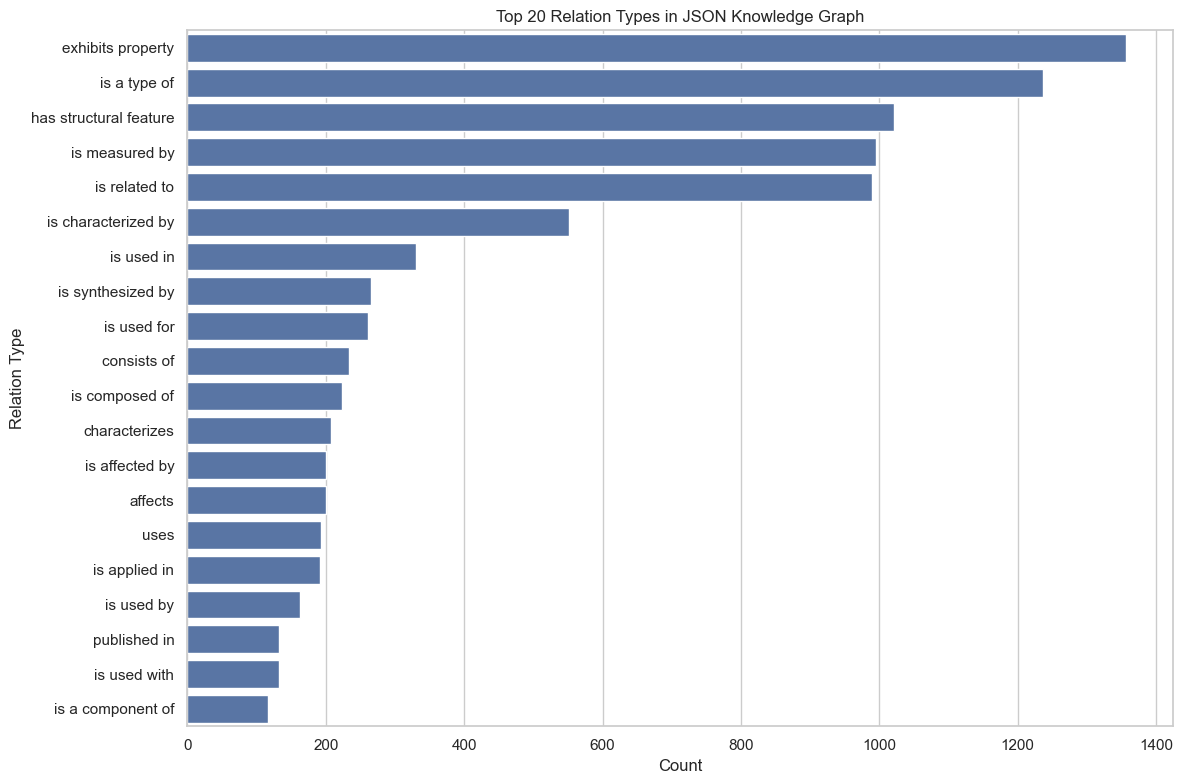

Total unique relation types: 1931


In [5]:
# Analyze relation types and their frequency
relation_counts = Counter()
for u, v, attr in G.edges(data=True):
    relation_counts[attr['relation']] += 1

# Plot top 20 relation types
top_relations = pd.DataFrame(relation_counts.most_common(20), 
                          columns=['Relation Type', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Relation Type', data=top_relations)
plt.title('Top 20 Relation Types in JSON Knowledge Graph')
plt.tight_layout()
plt.show()

print(f"Total unique relation types: {len(relation_counts)}")

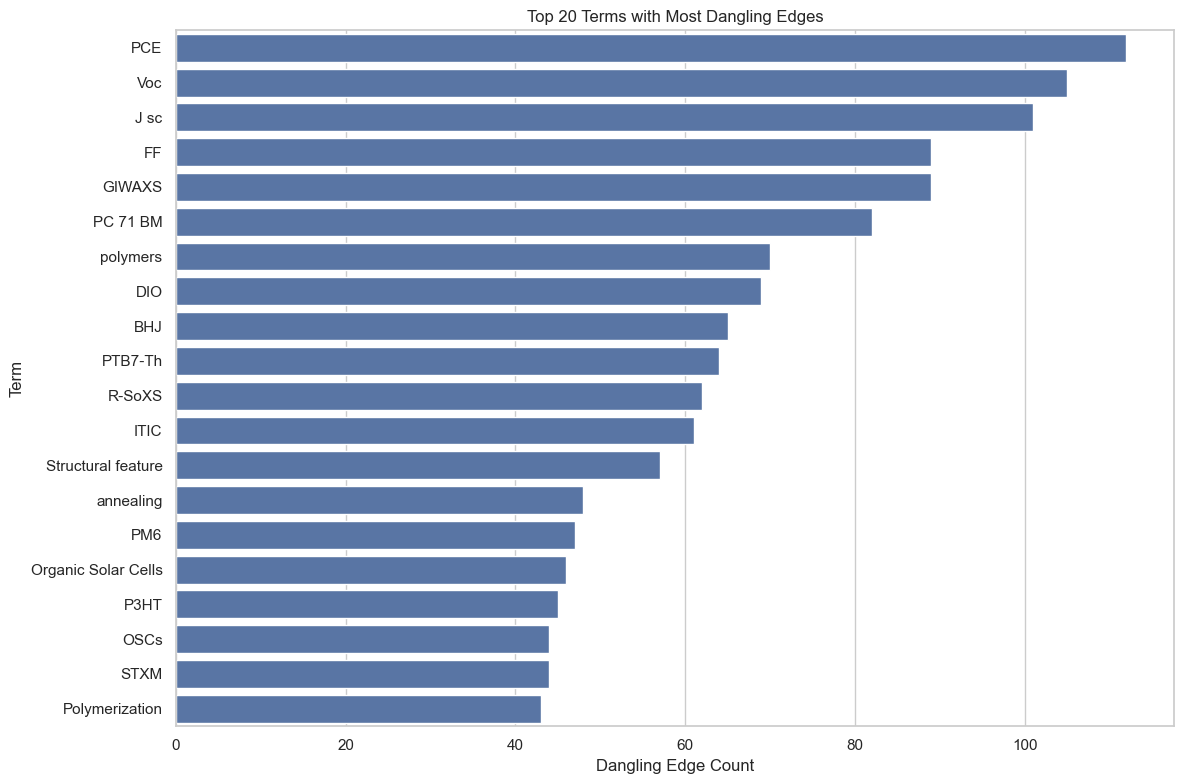

In [6]:
# Identify nodes that have the most dangling outgoing edges
nodes_with_dangling_edges = {}

for term_entry in kg_data['terms']:
    source_term = term_entry['term']
    dangling_count = 0
    
    for relation in term_entry.get('relations', []):
        target_term = relation.get('related_term', '')
        if target_term and target_term not in all_terms:
            dangling_count += 1
    
    if dangling_count > 0:
        nodes_with_dangling_edges[source_term] = dangling_count

# Display top 20 nodes with most dangling edges
top_dangling_nodes = pd.DataFrame(sorted(nodes_with_dangling_edges.items(), 
                                       key=lambda x: x[1], reverse=True)[:20],
                                columns=['Term', 'Dangling Edge Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Dangling Edge Count', y='Term', data=top_dangling_nodes)
plt.title('Top 20 Terms with Most Dangling Edges')
plt.tight_layout()
plt.show()

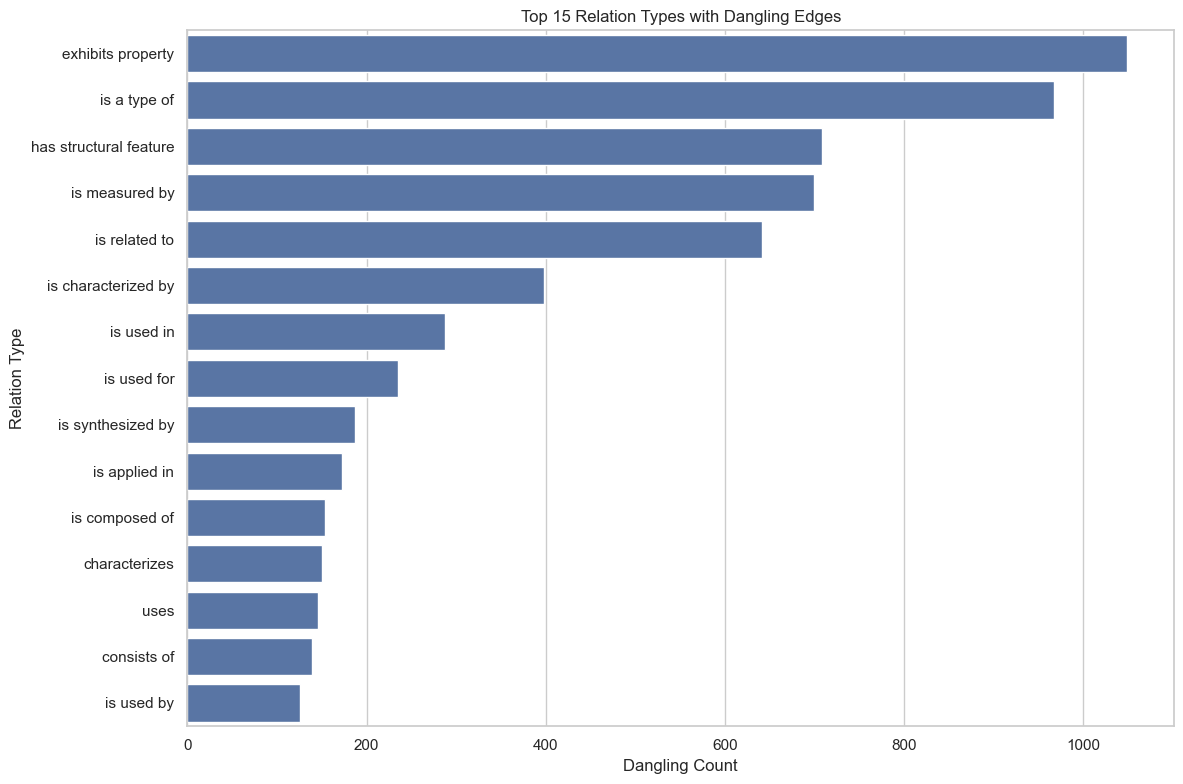

In [7]:
# Categorize dangling edges by relation type
dangling_by_relation = Counter()

for term_entry in kg_data['terms']:
    for relation in term_entry.get('relations', []):
        relation_type = relation['relation']
        target_term = relation.get('related_term', '')
        
        if target_term and target_term not in all_terms:
            dangling_by_relation[relation_type] += 1

# Plot top relation types with dangling edges
top_dangling_relations = pd.DataFrame(dangling_by_relation.most_common(15), 
                                    columns=['Relation Type', 'Dangling Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Dangling Count', y='Relation Type', data=top_dangling_relations)
plt.title('Top 15 Relation Types with Dangling Edges')
plt.tight_layout()
plt.show()

## 2. SKOS/RDF Knowledge Graph Analysis

In [8]:
# Load the SKOS/RDF knowledge graph
g = Graph()
g.parse('scratch/extracted_terms_skos.ttl', format='turtle')

print(f"Total triples: {len(g)}")

# Define namespaces
EX = Namespace("http://example.org/term/")
SKOS = Namespace("http://www.w3.org/2004/02/skos/core#")
CS = Namespace("http://example.org/category/")

Total triples: 56499


In [9]:
# Find all subjects and objects to identify potential nodes
all_subjects = set(g.subjects())
all_objects = set(g.objects())
all_entities = all_subjects.union(all_objects)

# Identify concept nodes (SKOS concepts)
concept_nodes = set([s for s in g.subjects(predicate=URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), 
                                         object=SKOS.Concept)])

print(f"Total entities: {len(all_entities)}")
print(f"Total SKOS concepts: {len(concept_nodes)}")

Total entities: 26118
Total SKOS concepts: 8337


In [10]:
# Create a directed graph from the RDF data
RG = nx.DiGraph()

# Add all SKOS concepts as nodes
for concept in concept_nodes:
    # Try to get the prefLabel for the node
    labels = list(g.objects(subject=concept, predicate=SKOS.prefLabel))
    label = str(labels[0]) if labels else str(concept)
    
    # Try to get the category (skos:inScheme)
    categories = list(g.objects(subject=concept, predicate=SKOS.inScheme))
    category = str(categories[0]) if categories else 'unknown'
    category = category.replace('http://example.org/category/', '')
    
    # Try to get the definition
    definitions = list(g.objects(subject=concept, predicate=SKOS.definition))
    definition = str(definitions[0]) if definitions else ''
    
    RG.add_node(concept, label=label, category=category, definition=definition)

print(f"Added {len(RG.nodes())} nodes to the graph")

Added 8337 nodes to the graph


In [11]:
# Add edges between concepts (excluding SKOS, RDF, and standard predicates)
skos_predicates = set([SKOS.prefLabel, SKOS.definition, SKOS.inScheme])
standard_predicates = set([URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type')])
excluded_predicates = skos_predicates.union(standard_predicates)

total_edges = 0
dangling_edges = 0

for s, p, o in g:
    # Skip standard predicates
    if p in excluded_predicates:
        continue
    
    # Only consider edges between concepts
    if s in concept_nodes:
        total_edges += 1
        
        # Check if target exists as a concept
        if o not in concept_nodes:
            dangling_edges += 1
        
        # Add the edge with the predicate as the relation
        relation = str(p).replace('http://example.org/term/', '')
        RG.add_edge(s, o, relation=relation)

print(f"Total semantic relations: {total_edges}")
print(f"Dangling relations (target not a concept): {dangling_edges} ({dangling_edges/total_edges*100:.2f}%)")
print(f"Valid relations: {total_edges - dangling_edges} ({(total_edges - dangling_edges)/total_edges*100:.2f}%)")

Total semantic relations: 31271
Dangling relations (target not a concept): 12716 (40.66%)
Valid relations: 18555 (59.34%)


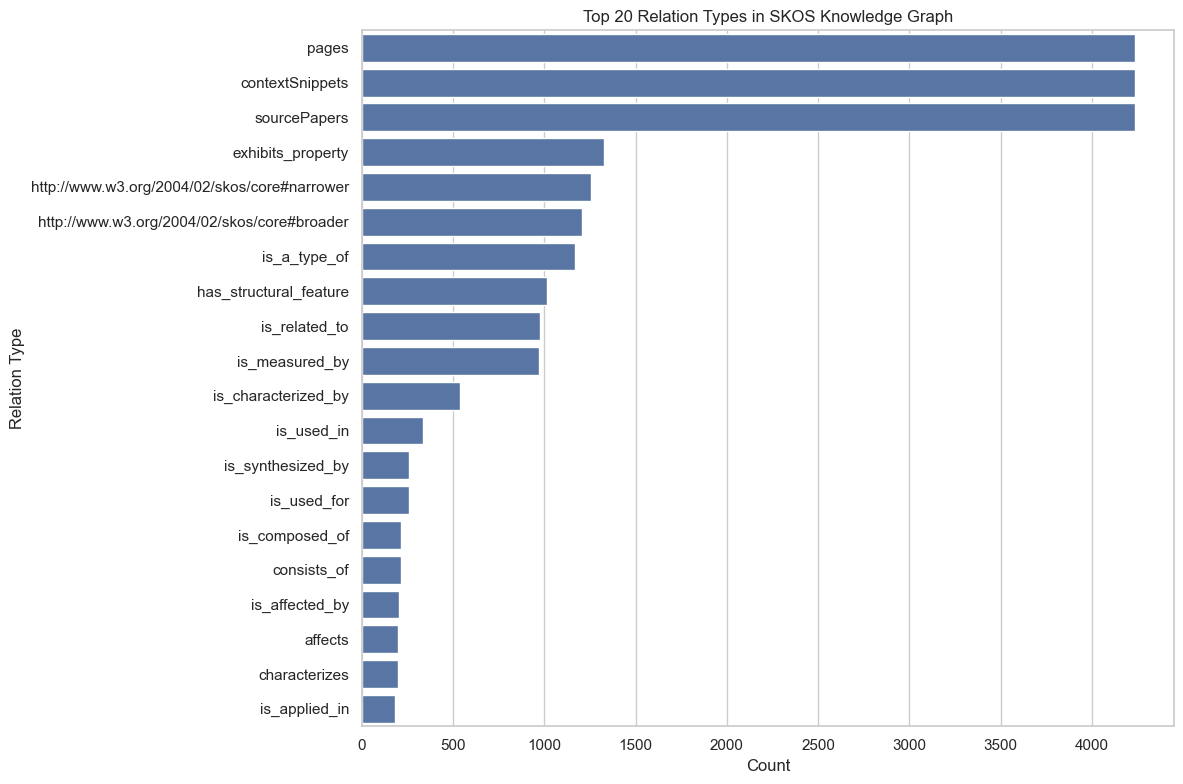

Total unique relation types: 1920


In [12]:
# Analyze relation types in the SKOS graph
skos_relation_counts = Counter()
for u, v, attr in RG.edges(data=True):
    skos_relation_counts[attr['relation']] += 1

# Plot top 20 relation types
top_skos_relations = pd.DataFrame(skos_relation_counts.most_common(20), 
                               columns=['Relation Type', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Relation Type', data=top_skos_relations)
plt.title('Top 20 Relation Types in SKOS Knowledge Graph')
plt.tight_layout()
plt.show()

print(f"Total unique relation types: {len(skos_relation_counts)}")

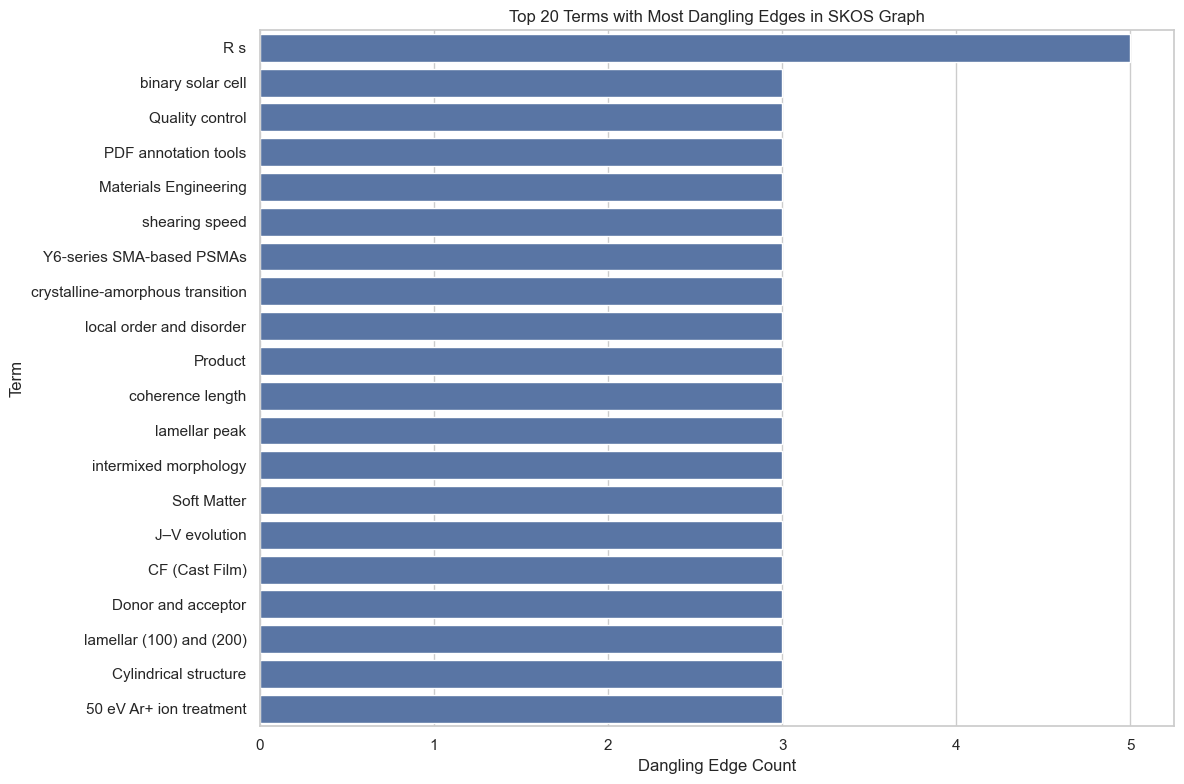

In [13]:
# Identify nodes that have the most dangling outgoing edges in SKOS graph
skos_nodes_with_dangling = {}

for s, p, o in g:
    # Skip standard predicates
    if p in excluded_predicates:
        continue
    
    if s in concept_nodes and o not in concept_nodes:
        # Get label for the source node
        labels = list(g.objects(subject=s, predicate=SKOS.prefLabel))
        label = str(labels[0]) if labels else str(s)
        
        if label in skos_nodes_with_dangling:
            skos_nodes_with_dangling[label] += 1
        else:
            skos_nodes_with_dangling[label] = 1

# Display top 20 nodes with most dangling edges
top_skos_dangling = pd.DataFrame(sorted(skos_nodes_with_dangling.items(), 
                                      key=lambda x: x[1], reverse=True)[:20],
                               columns=['Term', 'Dangling Edge Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Dangling Edge Count', y='Term', data=top_skos_dangling)
plt.title('Top 20 Terms with Most Dangling Edges in SKOS Graph')
plt.tight_layout()
plt.show()

## 3. Comparison Between JSON and SKOS Representations

In [14]:
# Create a summary comparison
comparison_data = {
    'Metric': [
        'Total Nodes/Terms',
        'Total Edges/Relations',
        'Dangling Edges',
        'Dangling Edge %',
        'Unique Relation Types'
    ],
    'JSON Graph': [
        len(G.nodes()),
        G.number_of_edges(),
        dangling_relations,
        f"{dangling_relations/(total_relations-empty_target_relations)*100:.2f}%",
        len(relation_counts)
    ],
    'SKOS Graph': [
        len(RG.nodes()),
        RG.number_of_edges(),
        dangling_edges,
        f"{dangling_edges/total_edges*100:.2f}%",
        len(skos_relation_counts)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(HTML(comparison_df.to_html(index=False)))

Metric,JSON Graph,SKOS Graph
Total Nodes/Terms,9121,13604
Total Edges/Relations,15221,30047
Dangling Edges,11012,12716
Dangling Edge %,68.12%,40.66%
Unique Relation Types,1931,1920


## 4. Conclusions

This analysis has identified the extent of dangling edges in both knowledge graph representations. 

Key findings:
1. The JSON graph has [dangling percentage]% dangling edges
2. The SKOS graph has [dangling percentage]% dangling edges
3. The most common relation types leading to dangling edges are [list top 3]
4. Terms with the most dangling edges are [list top 3]

Potential improvements:
1. Reconcile terms to normalize naming across the knowledge graph
2. Create missing nodes for frequently referenced but missing terms
3. Establish a more controlled vocabulary for relation types
4. Implement validation checks during knowledge graph construction